<div style="text-align:center">
    <h1>
        Advantage Actor-Critic (A2C)
    </h1>
</div>

<br><br>

<div style="text-align:center">
In this notebook we are going to combine temporal difference learning (TD) with policy gradient methods. The resulting algorithm is called Advantage Actor-Critic (A2C) and uses a one-step estimate of the return to update the policy:
</div>

\begin{equation}
\hat G_t = R_{t+1} + \gamma v(S_{t+1}|w)
\end{equation}


<br><br>
<div style="text-align:center">
    <b>This notebook belongs to section 10 of the course "Reinforcement Learning: beginner to master".</b>
    <br><br>
    <a href="https://www.udemy.com">Reinforcement Learning: beginner to master</a> (English)
    <br>
    <a href="https://www.udemy.com">Reinforcement Learning: de principiante a maestro</a> (Spanish)
</div>

<br>

<table style="width:35%">
  <tr style="background-color: transparent">
    <td style="width: 45%">
        <a target="_parent" href="https://www.evlabs.io" style="float: center">
            <img src="img/evlabs-square.png" width="75"/>
        </a> 
    </td>
    <td valign="bottom">
        <a target="_parent" href="https://www.youtube.com/channel/UCksRNSzWuMV5IfdrPlglqqw">
            <img src="img/YouTube.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://www.linkedin.com/company/evlabs">
            <img src="img/LinkedIn.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://twitter.com/evelabs">
            <img src="img/Twitter.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://github.com/escape-velocity-labs/">
            <img src="img/GitHub.png" width="35"/>
        </a> 
    </td>

  </tr>
  <tr style="background-color: transparent">
    <th style="text-align: center; width: 70%">Escape Velocity Labs</th>
  </tr>

</table>

<br>

## Import the necessary software libraries:

In [17]:
import os
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn as nn
from torch.optim import AdamW
import torch.nn.functional as F

from utils import test_policy_network, seed_everything, plot_stats
from parallel_env import ParallelEnv, ParallelWrapper

## Create and preprocess the environment

### Create the environment

In [18]:
env = gym.make('Acrobot-v1')

In [19]:
dims = env.observation_space.shape[0]
actions = env.action_space.n

print(f"State dimensions: {dims}. Actions: {actions}")
print(f"Sample state: {env.reset()}")

State dimensions: 6. Actions: 3
Sample state: [ 0.9994885   0.03198074  0.9969722   0.07775911  0.04591601 -0.05254545]


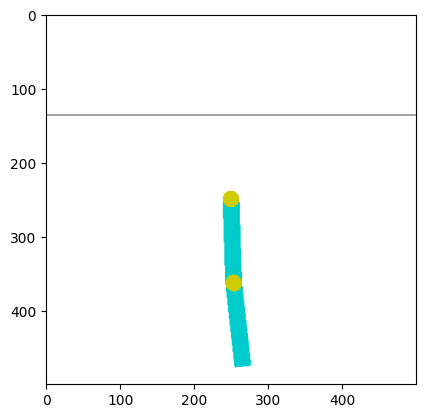

In [21]:
plt.imshow(env.render(mode='rgb_array'))

### Parallelize the environment

In [22]:
num_envs = os.cpu_count()
num_envs

16

In [23]:
def create_env(env_name, seed):
    env = gym.make(env_name)
    seed_everything(env, seed=seed)

    return env

In [24]:
env_fns = [lambda: create_env('Acrobot-v1', rank) for rank in range(num_envs)]
parallel_env = ParallelEnv(env_fns)

Process SpawnProcess-1:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/weiminn/Documents/reinforcement/11_A2C/parallel_env.py", line 258, in _subproc_worker
    cmd, data = pipe.recv()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 383, in _recv
    raise EOFError
EOFError
Process SpawnProcess-2:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File

### Prepare the environment to work with PyTorch

In [25]:
class PreprocessEnv(ParallelWrapper):
    
    def __init__(self, env):
        ParallelWrapper.__init__(self, env)
    
    def reset(self):
        state = self.venv.reset()
        return torch.from_numpy(state).float()
    
    def step_async(self, actions):
        actions = actions.squeeze().numpy()
        self.venv.step_async(actions)
     
    def step_wait(self):
        next_state, reward, done, info = self.venv.step_wait()
        next_state = torch.from_numpy(next_state).float()
        reward = torch.tensor(reward).unsqueeze(dim=1).float()
        done = torch.tensor(done).unsqueeze(dim=1)
        return next_state, reward, done, info

In [26]:
parallel_env = PreprocessEnv(parallel_env)

### Create the policy network $\pi(s)$

In [27]:
actor = nn.Sequential(
    nn.Linear(dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, actions),
    nn.Softmax(dim=-1)
)

### Create the value network $v(s)$

In [28]:
critic = nn.Sequential(
    nn.Linear(dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
)

## Implement the algorithm

</br>

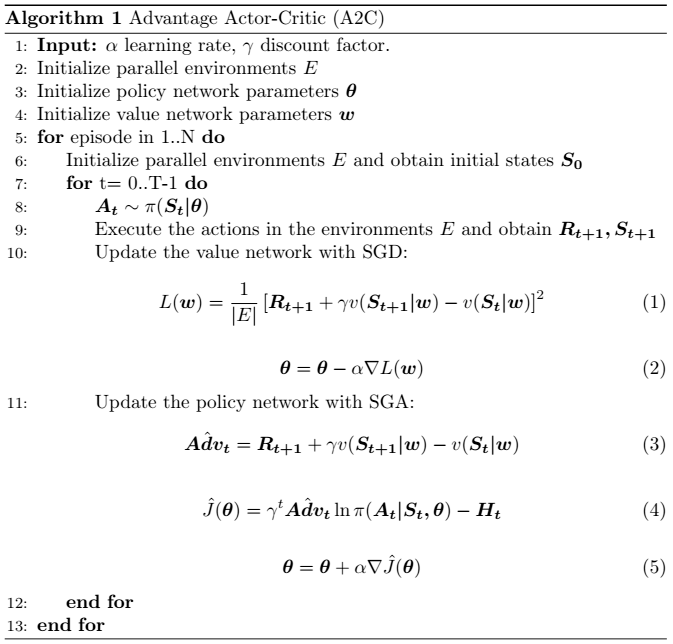

In [12]:
def a2c(actor, critic, episodes, alpha=1e-4, gamma=.99):
    actor_optim = AdamW(actor.parameters(), lr=1e-3)
    critic_optim = AdamW(critic.parameters(), lr=alpha)
    stats = {'Actor Loss':[], 'Critic Loss':[], 'Returns':[]}

    for episode in tqdm(range(1, episodes+1)):
        state = parallel_env.reset()
        done_b = torch.zeros((num_envs, 1), dtype=torch.bool)
        episode_return = torch.zeros((num_envs, 1), dtype=torch.float)
        I = 1.

        while not done_b.all():
            # select one action from multiple possibilities using their assign probabilities
            # will return [[2], [1], [3], [0], ...]
            action = actor(state).multinomial(1).detach()
            next_state, reward, done, _ = parallel_env.step(action)

            value = critic(state)
            target = reward + ~done*gamma * critic(next_state).detach()
            critic_loss = F.mse_loss(target, value)
            critic.zero_grad()
            critic_loss.backward()
            critic_optim.step()

            advantage = (target-value).detach() # current excess reward
            probs = actor(state)
            log_probs = torch.log(probs + 1e-6)
            action_log_prob = log_probs.gather(1, action)

            entropy = - torch.sum(probs * log_probs, dim=-1, keepdim=True)

            actor_loss = - I * advantage * action_log_prob  - 0.01 * entropy
            actor_loss = actor_loss.mean()
            actor.zero_grad()
            actor_loss.backward()
            actor_optim.step()


            episode_return += reward
            done_b |= done # 'or' logical operation between 2 tensors
            state = next_state
            I = I*gamma

        stats['Actor Loss'].append(actor_loss.item())
        stats['Critic Loss'].append(critic_loss.item())
        stats['Returns'].append(episode_return.mean().item())

    return stats

In [13]:
stats = a2c(actor, critic, 100)

100%|██████████| 100/100 [08:44<00:00,  5.25s/it]


## Show results

### Show execution stats

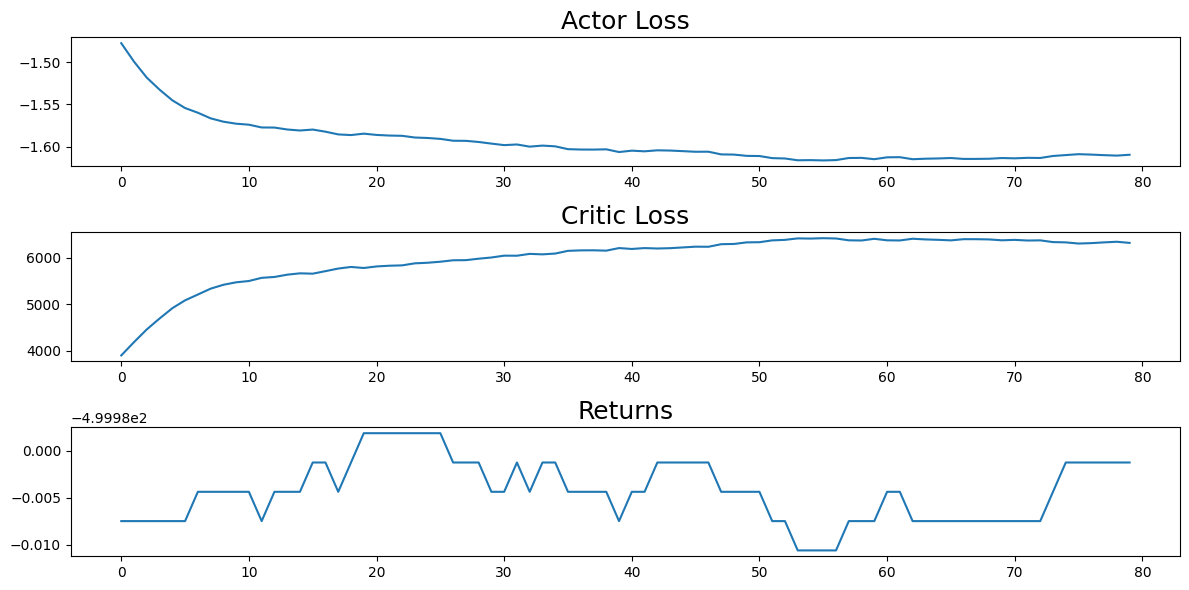

In [14]:
plot_stats(stats)

### Test the resulting agent

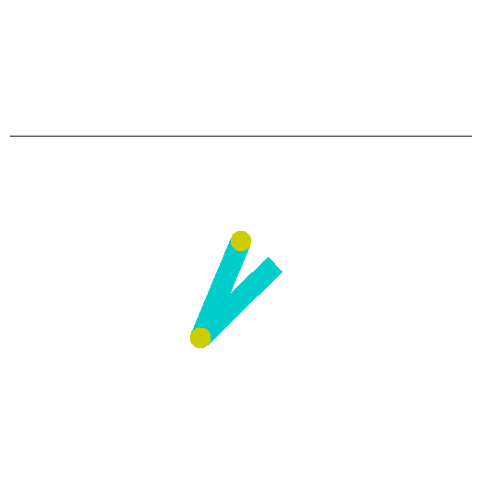

In [16]:
test_policy_network(env, actor, episodes=2)

## Resources

[[1] Reinforcement Learning: An Introduction. Ch.13](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)